# My current 1x8 and 1x12 bass speaker designs

Francis Deck

This notebook boils all of my design formulas down to a single Python function. It documents two of my designs: Good and bad:

* 12 inch ported system using Eminence 2512-ii driver. I've been quite happy with this design, it's a work horse, and I've been using it for well over a decade, both for electric and upright bass.

* 8 inch ported system using Faital Pro 8PR200, a high performance driver. This design suffers from port "chuffing" unless I use my own high pass filter. Even setting my filter at 35 Hz makes the chuffing go away. Still, I'm not entirely happy with a speaker design that requires additional electronics to make it even usable.

I decided to document and analyze both of my designs to serve as an example of using my formulas, plus to check the results carefully with the well known WinISD software.

## New instructions for use

* Download this notebook onto your hard drive.

* You can run Jupyter Lab in your browser with no software installation on your PC. Just surf to this link:

    https://jupyter.org/try-jupyter/lab/
    
* Click on "Upload Files"

    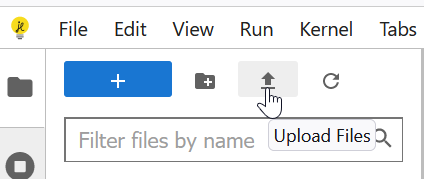
    
* Upload this notebook. It will appear in the list of files. Double-click on it. Now you're ready to go!

### License information

    The MIT License (MIT) Copyright (c) 2018-2022 Francis Deck

    Permission is hereby granted, free of charge, to any person obtaining a copy of this 
    software and associated documentation files (the "Software"), to deal in the Software 
    without restriction, including without limitation the rights to use, copy, modify, 
    merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
    to permit persons to whom the Software is furnished to do so, subject to the 
    following conditions:

    The above copyright notice and this permission notice shall be included in all 
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
    INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
    PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
    HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
    OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
    SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [4]:
from numpy import * # array math library
%matplotlib inline
from matplotlib.pyplot import *
import pandas as pd

In [31]:
# Physical constants

gamma = 1.4 # adiabatic constant, dimensionless
P_atm = 101325 # atmospheric pressure, Pa
rho = 1.225 # density of air, kg/m^3
c = sqrt(gamma*P_atm/rho) # https://en.wikipedia.org/wiki/Speed_of_sound
P_ref = 1 # reference power in Watts
R = 1 # listening distance in meters

f = logspace(1, 3, 300) # a range of frequencies from 10 to 1000 Hz
style = 'WinISD' # preferred style is 'Francis', use 'WinISD to compare results with the WinISD software'

def xCone(w = 2*pi*f, 
          F_s = 37, # free air resonance in Hz
          R_e= 5.04, # series resistance of voice coil in Ohms
          L_e = 0.46*0.001, # inductance of voice coil converted from mH to H
          Q_ms = 3.13, # mechanical contribution to Q factor
          Q_es = 0.44, # electromagnetic contribution to Q factor
          Vas = 147*0.001, # equivalent box volume, liters converted to m^3
          Xmax = 4.90*0.001, # maximum excursion, converted from mm to m
          S_d = 519.5/1e4, # cone area converted from cm^2 to m^2
          
          Znom = 8,
          Pin = 100, # input power used for calculations like cone excursion and port air speed
          V_box = 32*1e-3, # box volume, 32 l converted to m^3
          ported = True,
          f_port = 40, # port tuning frequency in Hz
          Q_port = 50,
          portShape = 'rectangular', # circular or rectangular
          d_port = 100*0.01, # diameter of port if circular in cm converted to m
          a_port = 3.5*0.01, # width of port if rectangular
          b_port = 21.5*0.01, # height of port if rectangular
          endCorrect = 0.732, # port end correction factor
          initReport = {},
          design = '',
         ):
    
    '''
    Compute cone excursion and other performance measures
    
    Parameters are self explanatory, all are in SI units
    '''
    
    w_0 = 2*pi*F_s # resonant frequency in radians/s
    m = gamma*P_atm*S_d**2/w_0**2/Vas # cone mass in kg
    BL = sqrt(w_0*m*R_e/Q_es) # BL product in T*m
    C = w_0*m/Q_ms # Mechanical damping constant of cone
    K = w_0**2*m # Spring constant of cone
    r = sqrt(S_d/pi) # Radius
    z = R_e + 1j*w*L_e # Electrical impedance
    if style == 'WinISD':
        K_box = gamma*P_atm*S_d**2/V_box # Spring constant of box
    elif style == 'Francis':
        Vin = sqrt(Pin*Znom) # Input voltage in Volts RMS
    else:
        print('style must be winISD or Francis')
    Vin = sqrt(Pin*R_e) # Input voltage in Volts RMS
    Vref = sqrt(P_ref*Znom) # Input voltage in Volts RMS
        
    if ported:
        w_port = 2*pi*f_port # port resonant frequency in radians/s
        kappa = w**2/(w**2 - 1j*w*w_port/Q_port - w_port**2) # correction factor for box spring constant based on port behavior
    else:
        kappa = 1 # i.e., no port therefore no port correction

    Keff = K + kappa*K_box # total spring constant, from driver suspension plus port-corrected box
    
    x = BL*Vin/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2) # cone excursion amplitude in meters

    Z = z/(1 - 1j*w*BL*x/Vin) # cone impedance, complex valued, in Ohms

    p = rho*r**2*w**2*kappa*x/R/2 # sound pressure amplitude in Pascal

    p_ref = 20e-6 # reference value for sound pressure, in Pascal
    spl = 20*log10(abs(p)/p_ref) # sound pressure level in dB SPL
    
    phaseRot = 180*pi/180 # phase rotation for phase graph, to make it agree with WinISD
    phase = angle(p*(cos(phaseRot) + 1j*sin(phaseRot)))*180/pi # phase of acoustic wavefront, nearfield
     
    # More ported behavior
    
    if ported:
        kappa2 = w_port**2/(w**2 - 1j*w*w_port/Q_port - w_port**2)
        
        if portShape == 'circular':
            S_port = pi*d_port**2/4
            Rport = d_port/2
        elif portShape == 'rectangular': 
            S_port = a_port*b_port
            Rport = min(a_port, b_port)/2 # assume effective radius is the smaller of the two dimensions
        else:
            print('portShape needs to be circular or rectangular')
        
        v_port = 1j*w*kappa2*x*S_d/S_port # speed of port air plug
        
        lport = S_port*gamma*P_atm/rho/V_box/w_port**2 - Rport*2*endCorrect # length of port in meters
        
    else:
        v_port = None
        
    report = dict(initReport)
    report['resonant angular frequency w_0 (1/s)'] = w_0
    report['cone mass m (kg)'] = m
    report['magnetic field length product BL (T m)'] = BL
    report['mechanical damping factor (N/(m/s))'] = C
    report['mechanical spring constant (N/m)'] = K
    report['mechanical compliance (m/N)'] = 1/K
    report['cone radius (m)'] = r
    report['box spring constant (N/m)'] = K_box
    report['Port angular frequency (1/s)'] = w_port
    report['Port area (m^2)'] = S_port
    report['Port effective radius (m)'] = Rport
    report['Length of port (m)'] = lport
    report['Length of port (in)'] = lport*39.3
        
    return x, Z, spl, phase, v_port, p, pd.DataFrame([[tag, report[tag]] for tag in report])

def graphs(f, x, Z, spl, phase, v_port, label):
    ax[0].semilogx(f, abs(x)*1000*1.414, label = label)
    ax[0].set_ylabel('cone excursion amplitude (mm)')
    ax[0].legend()
    
    ax[1].semilogx(f, abs(Z), label = label)
    ax[1].set_ylabel('impedance ($\Omega$)')
    ax[1].legend()

    ax[2].semilogx(f, spl, label = label)
    ax[2].set_ylabel('Sound pressure (dB SPL)')
    ax[2].legend()

    ax[3].semilogx(f, phase, label = label)
    ax[3].set_ylabel('Phase')
    ax[3].legend()

    #ax[4].semilogx(f, abs(v_port)*1.414/c, label = label)
    ax[4].semilogx(f, abs(v_port)*1.414, label = label)
    ax[4].set_xlabel('frequency (Hz)')
    ax[4].set_ylabel('port air speed (m/s)')
    #ax[4].set_ylabel('port air speed (mach)')
    ax[4].legend()
    
def runGraph(name, driver, box):
    x, Z, spl, phase, v_port, p1, df = xCone(**(name | driver | box), initReport = name | driver | box) 
    label = name['design']
    graphs(f, x, Z, spl, phase, v_port, label)
    return df

In [46]:
# Driver library.

emi2512ii = { # Eminence DeltaLite 2512-ii
    'F_s': 37, # resonant frequency in Hz
    'R_e': 5.04, # series resistance of voice coil in Ohms
    'L_e': 0.46*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 3.13, # mechanical contribution to Q factor
    'Q_es': 0.44, # electromagnetic contribution to Q factor
    'Vas': 147*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.90*0.001, # maximum excursion, converted from mm to m
    'S_d': 519.5/1e4, # cone area converted from cm^2 to m^2
}

fp8pr200 = { # Faital Pro 8PR200
    'F_s': 58, # resonant frequency in Hz
    'R_e': 5.1, # series resistance of voice coil in Ohms
    'L_e': 0.55*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 9.4, # mechanical contribution to Q factor
    'Q_es': 0.38, # electromagnetic contribution to Q factor
    'Vas': 16.9*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 8.15*0.001, # maximum excursion, converted from mm to m
    'S_d': 209/1e4, # cone area converted from cm^2 to m^2
}

# Box database

box1 = { # My little 12" box
    'Znom': 8,
    'Pin': 100,
    'V_box': 32*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 3.5*0.01, # width of port if rectangular
    'b_port': 21.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box2 = {
    'Znom': 8,
    'Pin': 100,
    'V_box': 12*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 5.5*0.01, # width of port if rectangular
    'b_port': 5.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

,0,1,2
0,design,1x12 ported,1x8 ported
1,F_s,37,58
2,R_e,5.04,5.1
3,L_e,0.00046,0.00055
4,Q_ms,3.13,9.4
5,Q_es,0.44,0.38
6,Vas,0.147,0.0169
7,Xmax,0.0049,0.00815
8,S_d,0.05195,0.0209
9,Znom,8,8


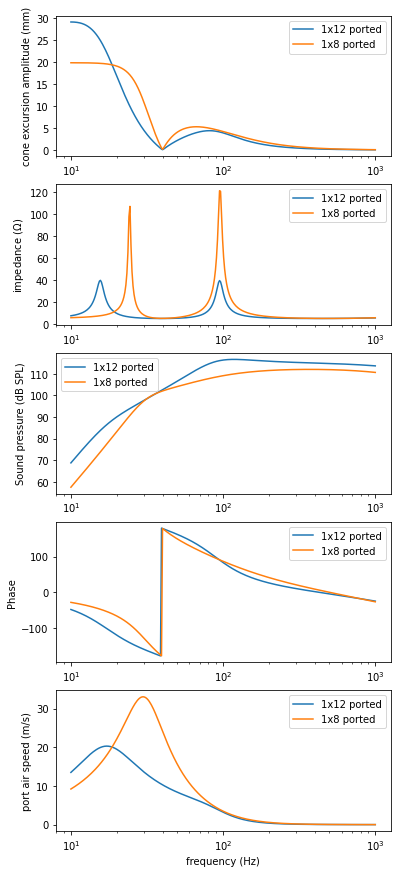

In [45]:
fig, ax = subplots(5, 1, figsize = (6, 15))

df1 = runGraph({'design': '1x12 ported'}, emi2512ii, box1)
df2 = runGraph({'design': '1x8 ported'}, fp8pr200, box2)

df1[2] = df2[1]
display(df1)

# Graphs for these designs from WinISD

There's a disagreement between me and WinISD, as to how we calculate the signal in Volts feeding the speaker, see above
for the "style" parameter. WinISD uses the $R_e$ of the coil, I use the nominal impedance. I've set the "style" to WinISD
for the purpose of comparison.

### Excursion amplitude
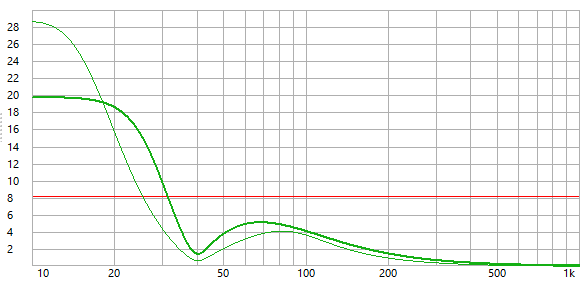

### Impedance
I get the same peak frequencies as WinISD, but noticeably different peak heights

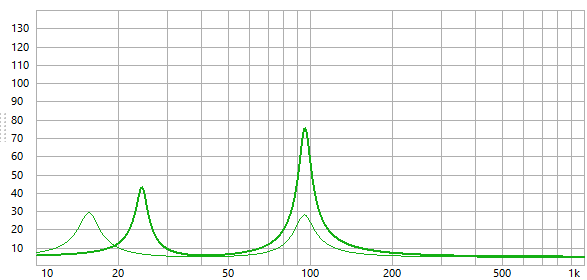

### SPL
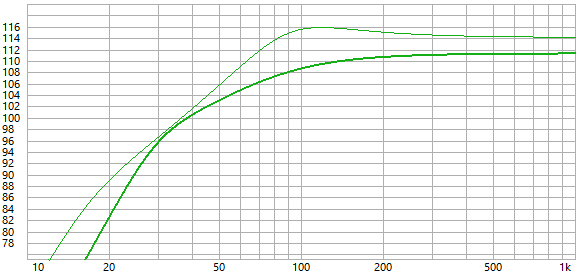

### Phase

I added a 180$^{\circ}$ phase rotation to make my graph match WinISD. This shouldn't have an acoustic effect, but is useful for comparing the programs.

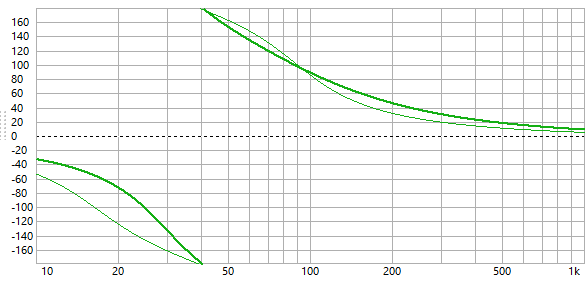

### Port air speed
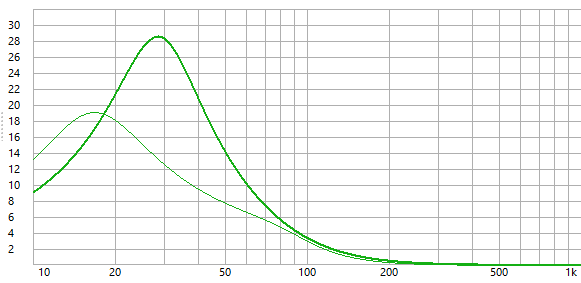